# Simulation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import parafac, tucker, parafac2
import warnings
from tensorly.cp_tensor import CPTensor
from tensorly.tucker_tensor import TuckerTensor, tucker_to_tensor
from tensorly.parafac2_tensor import parafac2_to_slices
from scipy.linalg import svd
import tlviz
from itertools import product
from kneed import KneeLocator
import math
from tensorly.parafac2_tensor import Parafac2Tensor, apply_parafac2_projections
from tlviz.model_evaluation import core_consistency

In [2]:
def data_visualization(patient1, patient2, patient3, tensor, name):
    patients = [patient1, patient2, patient3]
    titles = [name+ " Group A", name+ " Group B", name+ " Group C"]
    t = np.arange(len(tensor[0,:,0]))
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 3), sharey=True)
    
    for ax, patient, title in zip(axes, patients, titles):
        for i in range(100):
            ax.plot(t, tensor[i, :, patient])
        ax.set_title(title)
        ax.set_xlabel("Time")
    axes[0].set_ylabel("TCR Counts")
    plt.show()

In [3]:
def data_visualization2(patient1, patient2, patient3, tensor, name):
    patients = [patient1, patient2, patient3]
    titles = [name+ " Group A", name+ " Group B", name+ " Group C"]
    timesteps = [np.arange(tensor[patient1].shape[0]), np.arange(tensor[patient2].shape[0]), np.arange(tensor[patient3].shape[0])]

    fig, axes = plt.subplots(1, 3, figsize=(15, 3), sharey=True)
    
    for ax, patient, title, t in zip(axes, patients, titles, timesteps):
        for i in range(100):
            ax.plot(t, tensor[patient][:, i].T)
        ax.set_title(title)
        ax.set_xlabel("Time")
    axes[0].set_ylabel("TCR Counts")
    plt.show()

## CP Data: tensor_1

In [4]:
np.random.seed(41)

num_sequences = 100 
num_timesteps = 10 
num_patients = 10 

tensor_1 = np.abs(np.random.normal(0, 0.1, (num_sequences, num_timesteps, num_patients)))

t = np.arange(num_timesteps)
a = 0.2
b = 0.003
c = 0.1

for patient in range(num_patients):
    if patient in (0, 3, 5):
        tensor_1[0:2, :, patient] = a * (t[None, :] + 1) + np.abs(np.random.normal(0, 0.1, (2, num_timesteps)))

    elif patient in (1, 7, 9): 
        tensor_1[2:4, :, patient] = b * (t[None, :]) ** 3 + np.abs(np.random.normal(0, 0.1, (2, num_timesteps)))

    else:
        tensor_1[4:8, 0:5, patient] = c * t[None, 5] ** 2 - c * (t[::-1][None, 5:10] + 1) ** 2 + np.abs(np.random.normal(0, 0.1, (4, 5)))
        tensor_1[4:8, 5:10, patient] = - c * (t[None, 5:10] - 4) ** 2 + c * 5 ** 2 + np.abs(np.random.normal(0, 0.1, (4, 5)))

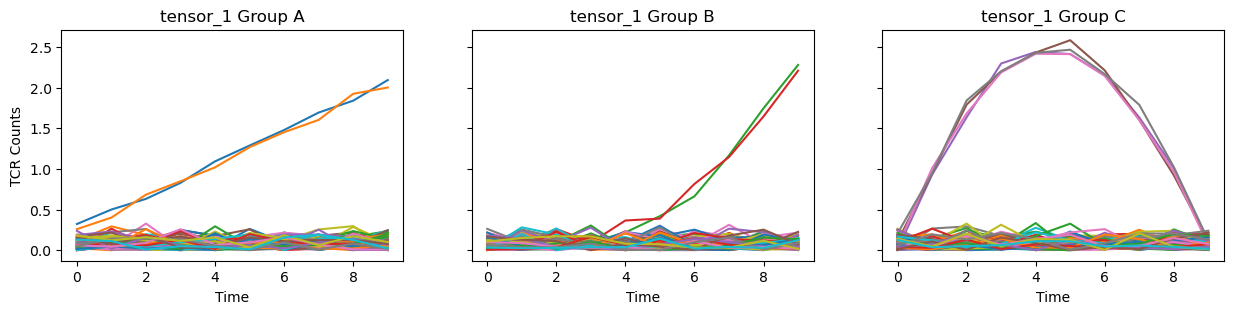

In [5]:
data_visualization(5, 9, 8, tensor_1, "tensor_1")

## Tucker Data: tensor_2

In [6]:
np.random.seed(42)

num_sequences = 100 
num_timesteps = 10 
num_patients = 10 

tensor_2 = np.abs(np.random.normal(0, 0.1, (num_sequences, num_timesteps, num_patients)))

t = np.arange(num_timesteps)
a = 0.2
b = 0.2
c = 0.1

for patient in range(num_patients):
    if patient in (0, 3, 5):
        tensor_2[0:2, :, patient] = a * (t[None, :] + 1) + np.abs(np.random.normal(0, 0.1, (2, num_timesteps)))

    elif patient in (1, 7, 9): 
        tensor_2[2:4, :, patient] = b * (t[None, :] + 1) + np.abs(np.random.normal(0, 0.1, (2, num_timesteps)))

    else:
        tensor_2[0:4, 0:5, patient] = c * t[None, 5] ** 2 - c * (t[::-1][None, 5:10] + 1) ** 2 + np.abs(np.random.normal(0, 0.1, (4, 5)))
        tensor_2[0:4, 5:10, patient] = - c * (t[None, 5:10] - 4) ** 2 + c * 5 ** 2 + np.abs(np.random.normal(0, 0.1, (4, 5)))

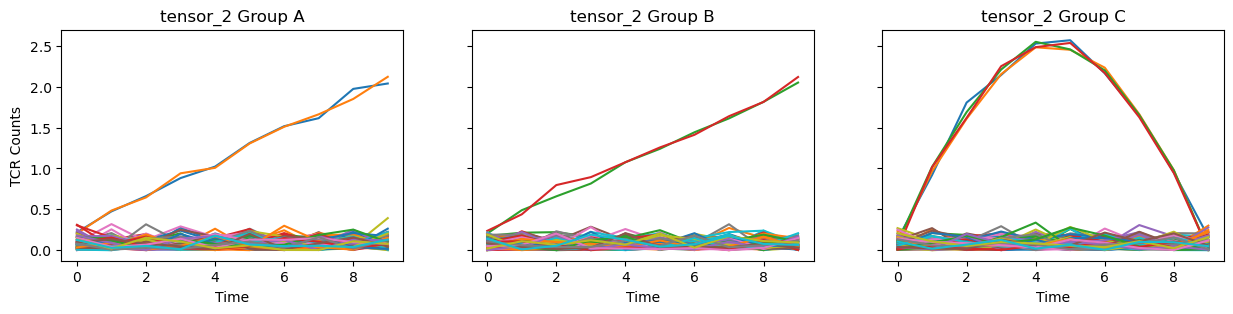

In [7]:
data_visualization(5, 9, 8, tensor_2, "tensor_2")

## PARAFAC2 Data_1: tensor_3

In [8]:
np.random.seed(41)

num_sequences = 100 
num_timesteps = np.random.randint(3, 20, size=10)*2
num_patients = 10 

tensor_3 = [np.abs(np.random.normal(0, 0.1, (timesteps, num_sequences))) for timesteps in num_timesteps]

a = 0.2
b = 0.003
c = 0.1

for patient in range(len(tensor_3)):
    
    t = np.arange(tensor_3[patient].shape[0])
    
    if patient in (0, 3, 5):
        tensor_3[patient][:, 0:2] = a * (t[:, None] + 1) + np.abs(np.random.normal(0, 0.1, (num_timesteps[patient], 2)))

    elif patient in (1, 7, 9): 
        tensor_3[patient][:, 2:4] = b * (t[:, None]) ** 3 + np.abs(np.random.normal(0, 0.1, (num_timesteps[patient], 2)))

    else:
        t_2 = math.ceil(num_timesteps[patient]/2)
        tensor_3[patient][0:t_2, 4:8] = c * t[t_2, None] ** 2 - c * (t[::-1][t_2:num_timesteps[patient], None] + 1) ** 2 + np.abs(np.random.normal(0, 0.1, (t_2, 4)))
        tensor_3[patient][t_2:num_timesteps[patient], 4:8] = - c * (t[t_2:num_timesteps[patient], None] - t_2-1) ** 2 + c * t_2 ** 2 + np.abs(np.random.normal(0, 0.1, (num_timesteps[patient]-t_2, 4)))

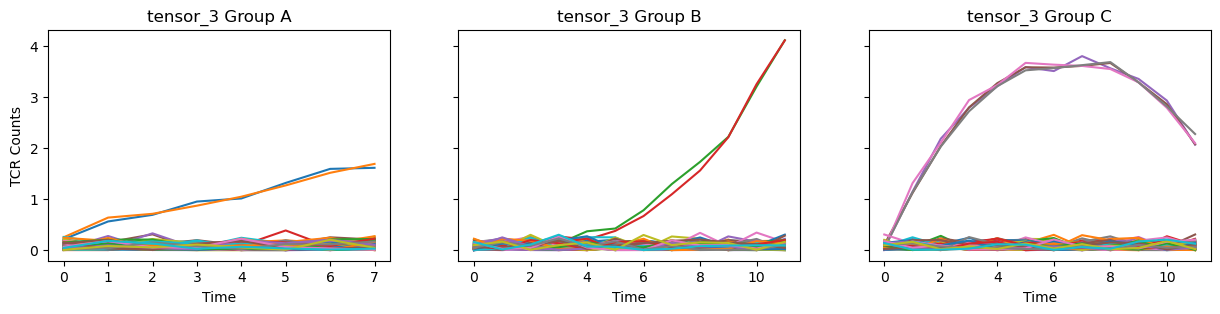

In [9]:
data_visualization2(5, 9, 8, tensor_3, "tensor_3")

## PARAFAC2 Data_2: tensor_4

In [10]:
np.random.seed(42)

num_sequences = 100 
num_timesteps = np.random.randint(3, 20, size=10)*2
num_patients = 10 

tensor_4 = [np.abs(np.random.normal(0, 0.1, (timesteps, num_sequences))) for timesteps in num_timesteps]

a = 0.2
b = 0.003
c = 0.1

for patient in range(len(tensor_3)):
    
    t = np.arange(tensor_4[patient].shape[0])
    
    if patient in (0, 3, 5):
        tensor_4[patient][:, 0:2] = a * (t[:, None] + 1) + np.abs(np.random.normal(0, 0.1, (num_timesteps[patient], 2)))

    elif patient in (1, 7, 9): 
        tensor_4[patient][:, 2:4] = b * (t[:, None]) ** 3 + np.abs(np.random.normal(0, 0.1, (num_timesteps[patient], 2)))

    else:
        t_2 = math.ceil(num_timesteps[patient]/2)
        tensor_4[patient][0:t_2, 0:2] = c * t[t_2, None] ** 2 - c * (t[::-1][t_2:num_timesteps[patient], None] + 1) ** 2 + np.abs(np.random.normal(0, 0.1, (t_2, 2)))
        tensor_4[patient][t_2:num_timesteps[patient], 0:2] = - c * (t[t_2:num_timesteps[patient], None] - t_2-1) ** 2 + c * t_2 ** 2 + np.abs(np.random.normal(0, 0.1, (num_timesteps[patient]-t_2, 2)))

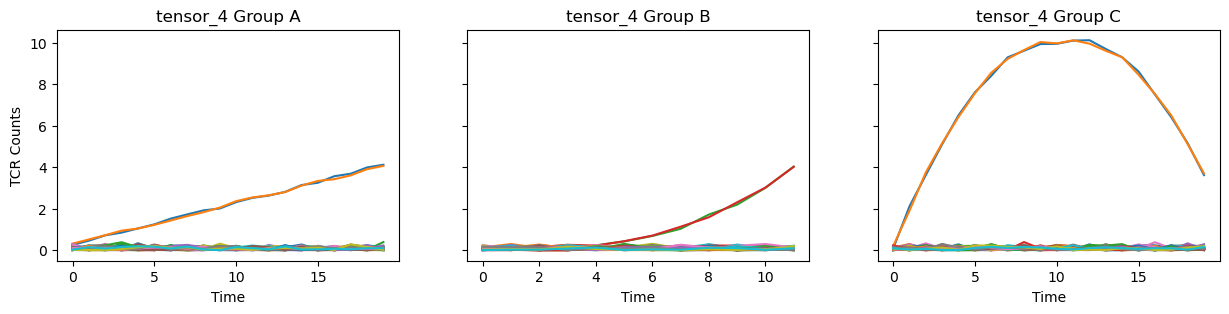

In [11]:
data_visualization2(3, 7, 8, tensor_4, "tensor_4")

## 0-1 Normalization

In [12]:
def norm_01scale(tensor, mode):
    sum_mode= np.sum(tensor, axis=mode, keepdims=True)
    sum_mode[sum_mode == 0] = 1
    return tensor / sum_mode

In [13]:
tensor_norm_1 = norm_01scale(tensor_1, 0)
tensor_norm_2 = norm_01scale(tensor_2, 0)
tensor_norm_3 = [norm_01scale(x, 1) for x in tensor_3]
tensor_norm_4 = [norm_01scale(x, 1) for x in tensor_4]

## Centering and scaling

In [14]:
def centering(tensor, mode):
    mean = np.mean(tensor, axis=mode, keepdims=True)
    return tensor - mean

In [15]:
tensor_cent_1 = centering(tensor_norm_1, 1)
tensor_cent_2 = centering(tensor_norm_2, 1)
tensor_cent_3 = [centering(t, 0) for t in tensor_norm_3]
tensor_scaled_3 = [x / np.linalg.norm(x) for x in tensor_cent_3]
tensor_cent_4 = [centering(t, 0) for t in tensor_norm_4]
tensor_scaled_4 = [x / np.linalg.norm(x) for x in tensor_cent_4]

## Saving

In [16]:
np.save('simulated_data/tensor_1.npy', tensor_cent_1)
np.save('simulated_data/tensor_2.npy', tensor_cent_2)
np.save('simulated_data/tensor_3.npy', np.array(tensor_scaled_3, dtype=object))
np.save('simulated_data/tensor_4.npy', np.array(tensor_scaled_4, dtype=object))